[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/08_Homework_MNIST_BoltzmannMachine.ipynb)

# Homework: Boltzmann Machines applied to MNIST

This shows how to train a Boltzmann machine, to sample from an observed probability distribution. It uses the MNIST digits images that are included in every keras installation.

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 9, Homework (this is discussed in session 10)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook is distributed under the Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license:

https://creativecommons.org/licenses/by-sa/4.0/

This notebook shows how to:
- use a Boltzmann machine to sample from an observed high-dimensional probability distribution (e.g. produce images that look similar to observed training images); applied to the case of MNIST

It also implements some of the tricks discussed by the inventor of RBM, G. Hinton, in

https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf

In [75]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

import tensorflow as tf ## -> just use this to import the MNIST dataset

from IPython.display import clear_output
from time import sleep

In [76]:
def BoltzmannStep(v,b,w,random_key,do_random_sampling=True):
    """
    Perform a single step of the Markov chain,
    going from visible units v to hidden units h,
    according to biases b and weights w.
    
    z_j = b_j + sum_i v_i w_ij
    
    and P(h_j=1|v) = 1/(exp(-z_j)+1)
    
    Note: you can go from h to v, by inserting
    instead of v the h, instead of b the a, and
    instead of w the transpose of w
    """
    batchsize=jnp.shape(v)[0]
    hidden_dim=jnp.shape(w)[1]
    z=b+jnp.dot(v,w)
    P=1/(jnp.exp(-z)+1)
    # now, the usual trick to obtain 0 or 1 according
    # to a given probability distribution:
    # just produce uniform (in [0,1]) random numbers and
    # check whether they are below the cutoff given by P
    if do_random_sampling:
        random_key,new_key = jax.random.split(random_key)
        p=jax.random.uniform(new_key,shape=[batchsize,hidden_dim])
        return new_key, jnp.array(p<=P,dtype='int')
    else:
        return random_key, P # no binary random output, just the prob. distribution itself!
    
def BoltzmannSequence(v,a,b,w,random_key,drop_h_prime=False,do_random_sampling=True,
                      do_not_sample_h_prime=False,do_not_sample_v_prime=False):
    """
    Perform one sequence of steps v -> h -> v' -> h'
    of a Boltzmann machine, with the given
    weights w and biases a and b!
    
    All the arrays have a shape [batchsize,num_neurons]
    (where num_neurons is num_visible for v and
    num_hidden for h)
    
    You can set drop_h_prime to True if you want to
    use this routine to generate arbitrarily long sequences
    by calling it repeatedly (then don't use h')
    Returns: v,h,v',h'
    """
    random_key, h = BoltzmannStep(v,b,w,random_key)
    random_key, v_prime = BoltzmannStep(h,a,np.transpose(w),random_key)

    if do_not_sample_v_prime:
        random_key,v_prime=BoltzmannStep(h,a,np.transpose(w),random_key,do_random_sampling=False)
    else:
        random_key,v_prime=BoltzmannStep(h,a,np.transpose(w),random_key,do_random_sampling=do_random_sampling)
    if not drop_h_prime:
        if do_not_sample_h_prime: # G. Hinton recommends not sampling in the v'->h' step (reduces noise)
            random_key,h_prime=BoltzmannStep(v_prime,b,w,random_key,do_random_sampling=False)
        else:
            random_key,h_prime=BoltzmannStep(v_prime,b,w,random_key,do_random_sampling=do_random_sampling)
    else:
        h_prime=np.zeros(np.shape(h))

    return random_key,v,h,v_prime,h_prime

def trainStep(v,a,b,w,random_key,drop_h_prime=False,do_random_sampling=True,
                      do_not_sample_h_prime=False,do_not_sample_v_prime=False):
    """
    Given a set of randomly selected training samples
    v (of shape [batchsize,num_neurons_visible]), 
    and given biases a,b and weights w: update
    those biases and weights according to the
    contrastive-divergence update rules:
    
    delta w_ij = eta ( <v_i h_j> - <v'_i h'_j> )
    delta a_i  = eta ( <v_i> - <v'_i>)
    delta b_j  = eta ( <h_j> - <h'_j>)
    
    Returns delta_a, delta_b, delta_w, but without the eta factor!
    It is up to you to update a,b,w!
    """
    random_key,v,h,v_prime,h_prime=BoltzmannSequence(v,a,b,w,random_key,drop_h_prime=drop_h_prime,do_random_sampling=do_random_sampling,
                      do_not_sample_h_prime=do_not_sample_h_prime,do_not_sample_v_prime=do_not_sample_v_prime)
    return( random_key,
            jnp.average(v,axis=0)-jnp.average(v_prime,axis=0) ,
            jnp.average(h,axis=0)-jnp.average(h_prime,axis=0) ,
            jnp.average(v[:,:,None]*h[:,None,:],axis=0)-
               jnp.average(v_prime[:,:,None]*h_prime[:,None,:],axis=0) )


In [77]:
def produce_sample_images(batchsize,num_visible,x_train,random_key,threshold=0.7,do_digitize=True):
    """
    Produce 'batchsize' samples, of length num_visible.
    Returns array v of shape [batchsize,num_visible].
    Note: num_visible needs to be equal to the number of pixels in one image (here 28*28).
    """

    random_key,new_key = jax.random.split(random_key)
    j=jax.random.randint(new_key,minval=0,maxval=jnp.size(x_train,0),shape=[batchsize])  # pick random samples
    
    # reshape suitably, and digitize (so output is 0/1 values)
    if do_digitize:
        return( np.array( np.reshape(x_train[j,:,:],[batchsize,num_visible])>threshold, dtype='int' ) )
    else:
        return(  np.reshape(x_train[j,:,:],[batchsize,num_visible]) )

In [78]:
# Load the MNIST data using tensorflow/keras
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data(path="mnist.npz")

## convert to jax
x_train = jnp.array(x_train)
y_train = jnp.array(y_train)

x_train=x_train/256.

In [79]:
# Show the shape of these arrays
print(jnp.shape(x_train),jnp.shape(y_train),jnp.shape(x_test),jnp.shape(y_test))

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


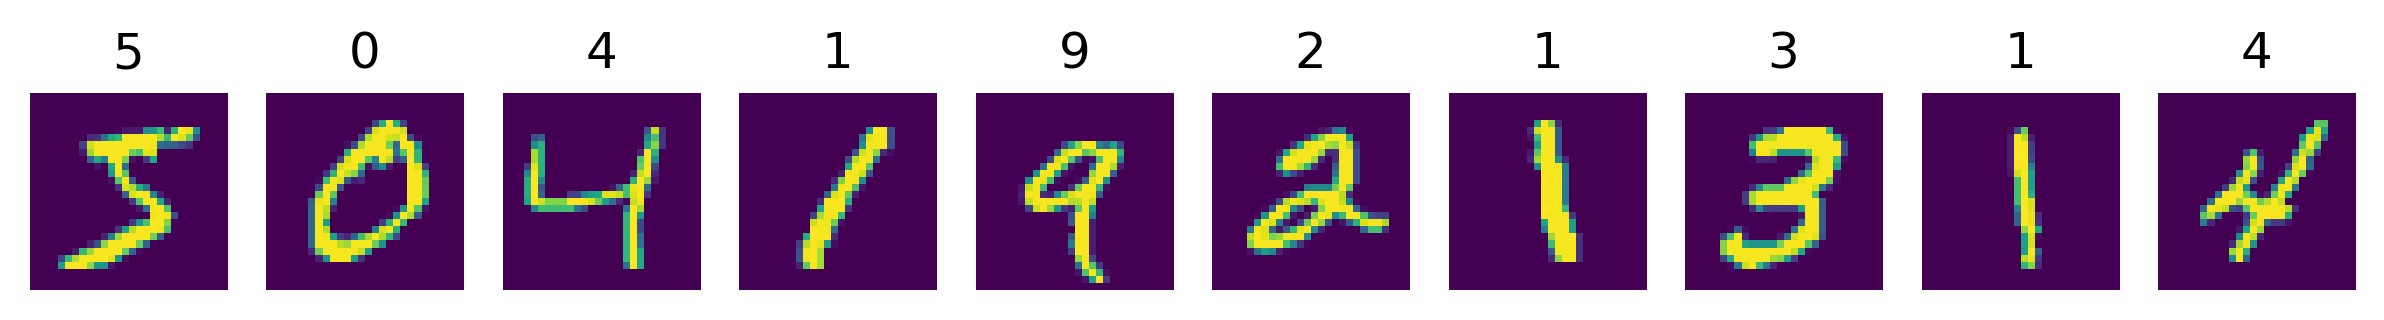

In [80]:
# display a few images, for fun
nimages=10
fig,ax=plt.subplots(ncols=nimages,nrows=1,figsize=(nimages,1))
for n in range(nimages):
    ax[n].imshow(x_train[n,:,:])
    ax[n].set_title(str(y_train[n])) # the label
    ax[n].axis('off')
plt.show()

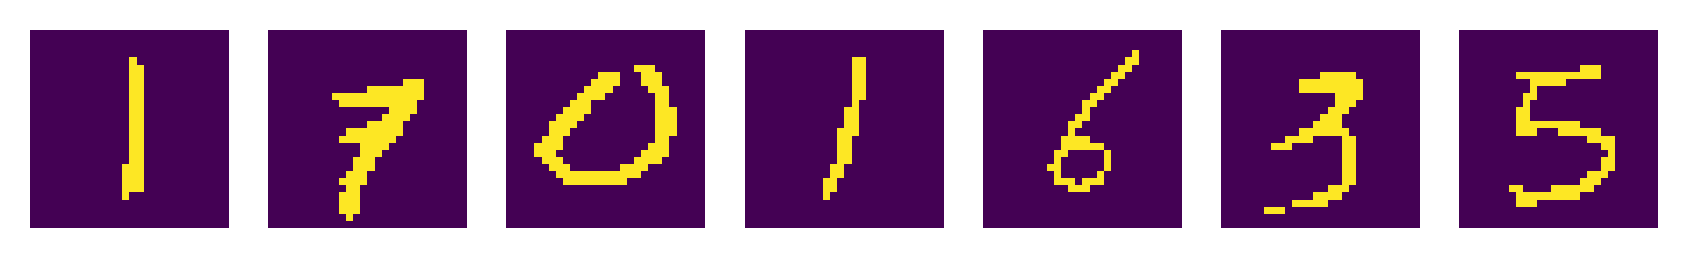

In [81]:
# pick a few random samples:
nimages=7
Npixels=28
random_key = jax.random.key(42) # first 'key', like setting a random seed
samples=produce_sample_images(batchsize=nimages,num_visible=Npixels**2,x_train=x_train,random_key=random_key)
# now unpack them again and display them:
fig,ax=plt.subplots(ncols=nimages,nrows=1,figsize=(nimages,1))
for n in range(nimages):
    ax[n].imshow(np.reshape(samples[n,:],[Npixels,Npixels]))
    ax[n].axis('off')
plt.show()

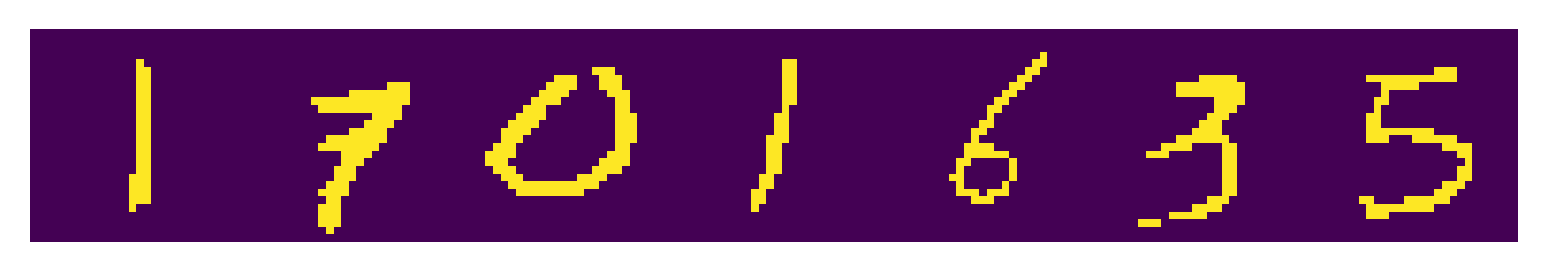

In [82]:
# a little trick (useful later): show them all at once, in one imshow
# some weird reshape/transpose gymnastics, found by trial and error
plt.imshow(jnp.transpose(jnp.reshape(jnp.transpose(jnp.reshape(samples,[nimages,Npixels,Npixels]),
                                                axes=[0,2,1]),[nimages*Npixels,Npixels])))
plt.axis('off')
plt.show()

## Basic training, according to the simple principle of an RBM presented in the lecture (all units are binary 0 or 1 all the time, randomly chosen according to the calculated probability distribution)

In [83]:
# Now: the training
# here: purely using random binary sampling of all
# units at all times (this is not the most efficient way,
# but implements directly the basic principle shown in the lecture)

Npixels=28
num_visible=Npixels**2
num_hidden=60
batchsize=50
eta=0.1
nsteps=10000
skipsteps=10

random_key = jax.random.key(42) # first 'key', like setting a random seed

random_key,new_key = jax.random.split(random_key)
a=jax.random.uniform(new_key,shape=(num_visible,))

random_key,new_key = jax.random.split(random_key)
b=jax.random.uniform(new_key,shape=(num_hidden,))

random_key,new_key = jax.random.split(random_key)
w=0.01 * jax.random.uniform(new_key,shape=(num_visible,num_hidden))

# test_samples=np.zeros([num_visible,nsteps])

for j in range(nsteps):
    v=produce_sample_images(batchsize,num_visible,x_train,random_key)
    random_key,da,db,dw=trainStep(v,a,b,w,random_key)
    a+=eta*da
    b+=eta*db
    w+=eta*dw
    print("{:05d} / {:05d}".format(j,nsteps),end="   \r")


/var/folders/l4/twwc2gvj5kd4ykzr0yk_m5zr0000gn/T/ipykernel_48409/481770643.py:26: UserWarning: Explicitly requested dtype int requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return new_key, jnp.array(p<=P,dtype='int')


In [94]:
v=produce_sample_images(batchsize,num_visible,x_train,random_key) ## set v to some initial batch of images image you would like to start sampling from via a Boltzmann Sequence

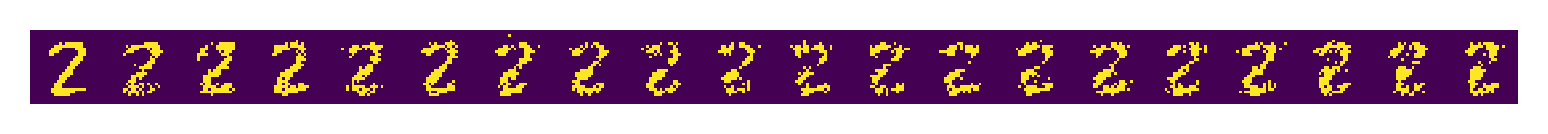

In [95]:
# Now: visualize the typical samples generated (from some starting point)
# run several times to continue this. It basically is a random walk
# through the space of all possible configurations, hopefully according
# to the probability distribution that has been trained!

#nsteps=1000
nsteps=20
num_samples=20
test_samples=jnp.zeros([num_samples,num_visible])
skipsteps=1
substeps=400 # how many steps to take before showing a new picture

v_prime=jnp.zeros(num_visible)
h=jnp.zeros(num_hidden)
h_prime=jnp.zeros(num_hidden)

for j in range(nsteps):
    for k in range(substeps):
        random_key,v,h,v_prime,h_prime=BoltzmannSequence(v,a,b,w,random_key,drop_h_prime=True) # step from v via h to v_prime!
    test_samples=test_samples.at[j%num_samples,:].set(v[0,:])
    v=jnp.copy(v_prime) # use the new v as a starting point for next step!
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        plt.imshow(jnp.transpose(jnp.reshape(jnp.transpose(jnp.reshape(test_samples,[num_samples,Npixels,Npixels]),
                                                axes=[0,2,1]),[num_samples*Npixels,Npixels])),
                  interpolation='none')
        plt.axis('off')
        plt.show()

## More advanced training: do not randomly sample h' and v'

In [71]:
# Now: the training
#
# Here we use the more sophisticated approach, where
# h' and v' are not binary (not randomly sampled), rather
# they are taken as the probability distribution (numbers
# between 0 and 1). This is a trick recommend by G. Hinton
# in his review of Boltzmann Machines. It effectively means
# less sampling noise.
#
# Also, we initialize the biases and weights according to the
# tricks given in that review!

Npixels=28
num_visible=Npixels**2
num_hidden=60
batchsize=10
eta=0.0001
nsteps=10*30000
skipsteps=10

# get average brightness of training images:
p_avg=jnp.average(np.reshape(x_train,[jnp.shape(x_train)[0],Npixels**2]),axis=0)
a=jnp.log(p_avg/(1.0+1e-6-p_avg)+1e-6) # recipe for visible biases
b=jnp.zeros(num_hidden) # recipe for hidden biases

random_key,new_key = jax.random.split(random_key)
w=0.01 * jax.random.uniform(new_key,shape=(num_visible,num_hidden)) # recipe for weights

# test_samples=np.zeros([num_visible,nsteps])

for j in range(nsteps):
    v=produce_sample_images(batchsize,num_visible,x_train,random_key,
                           do_digitize=False)
    random_key,da,db,dw=trainStep(v,a,b,w,random_key,
                      do_not_sample_h_prime=True,
                       do_not_sample_v_prime=True)
    a+=eta*da
    b+=eta*db
    w+=eta*dw
    print("{:06d} / {:06d}".format(j,nsteps),end="   \r")



/var/folders/l4/twwc2gvj5kd4ykzr0yk_m5zr0000gn/T/ipykernel_48409/481770643.py:26: UserWarning: Explicitly requested dtype int requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return new_key, jnp.array(p<=P,dtype='int')


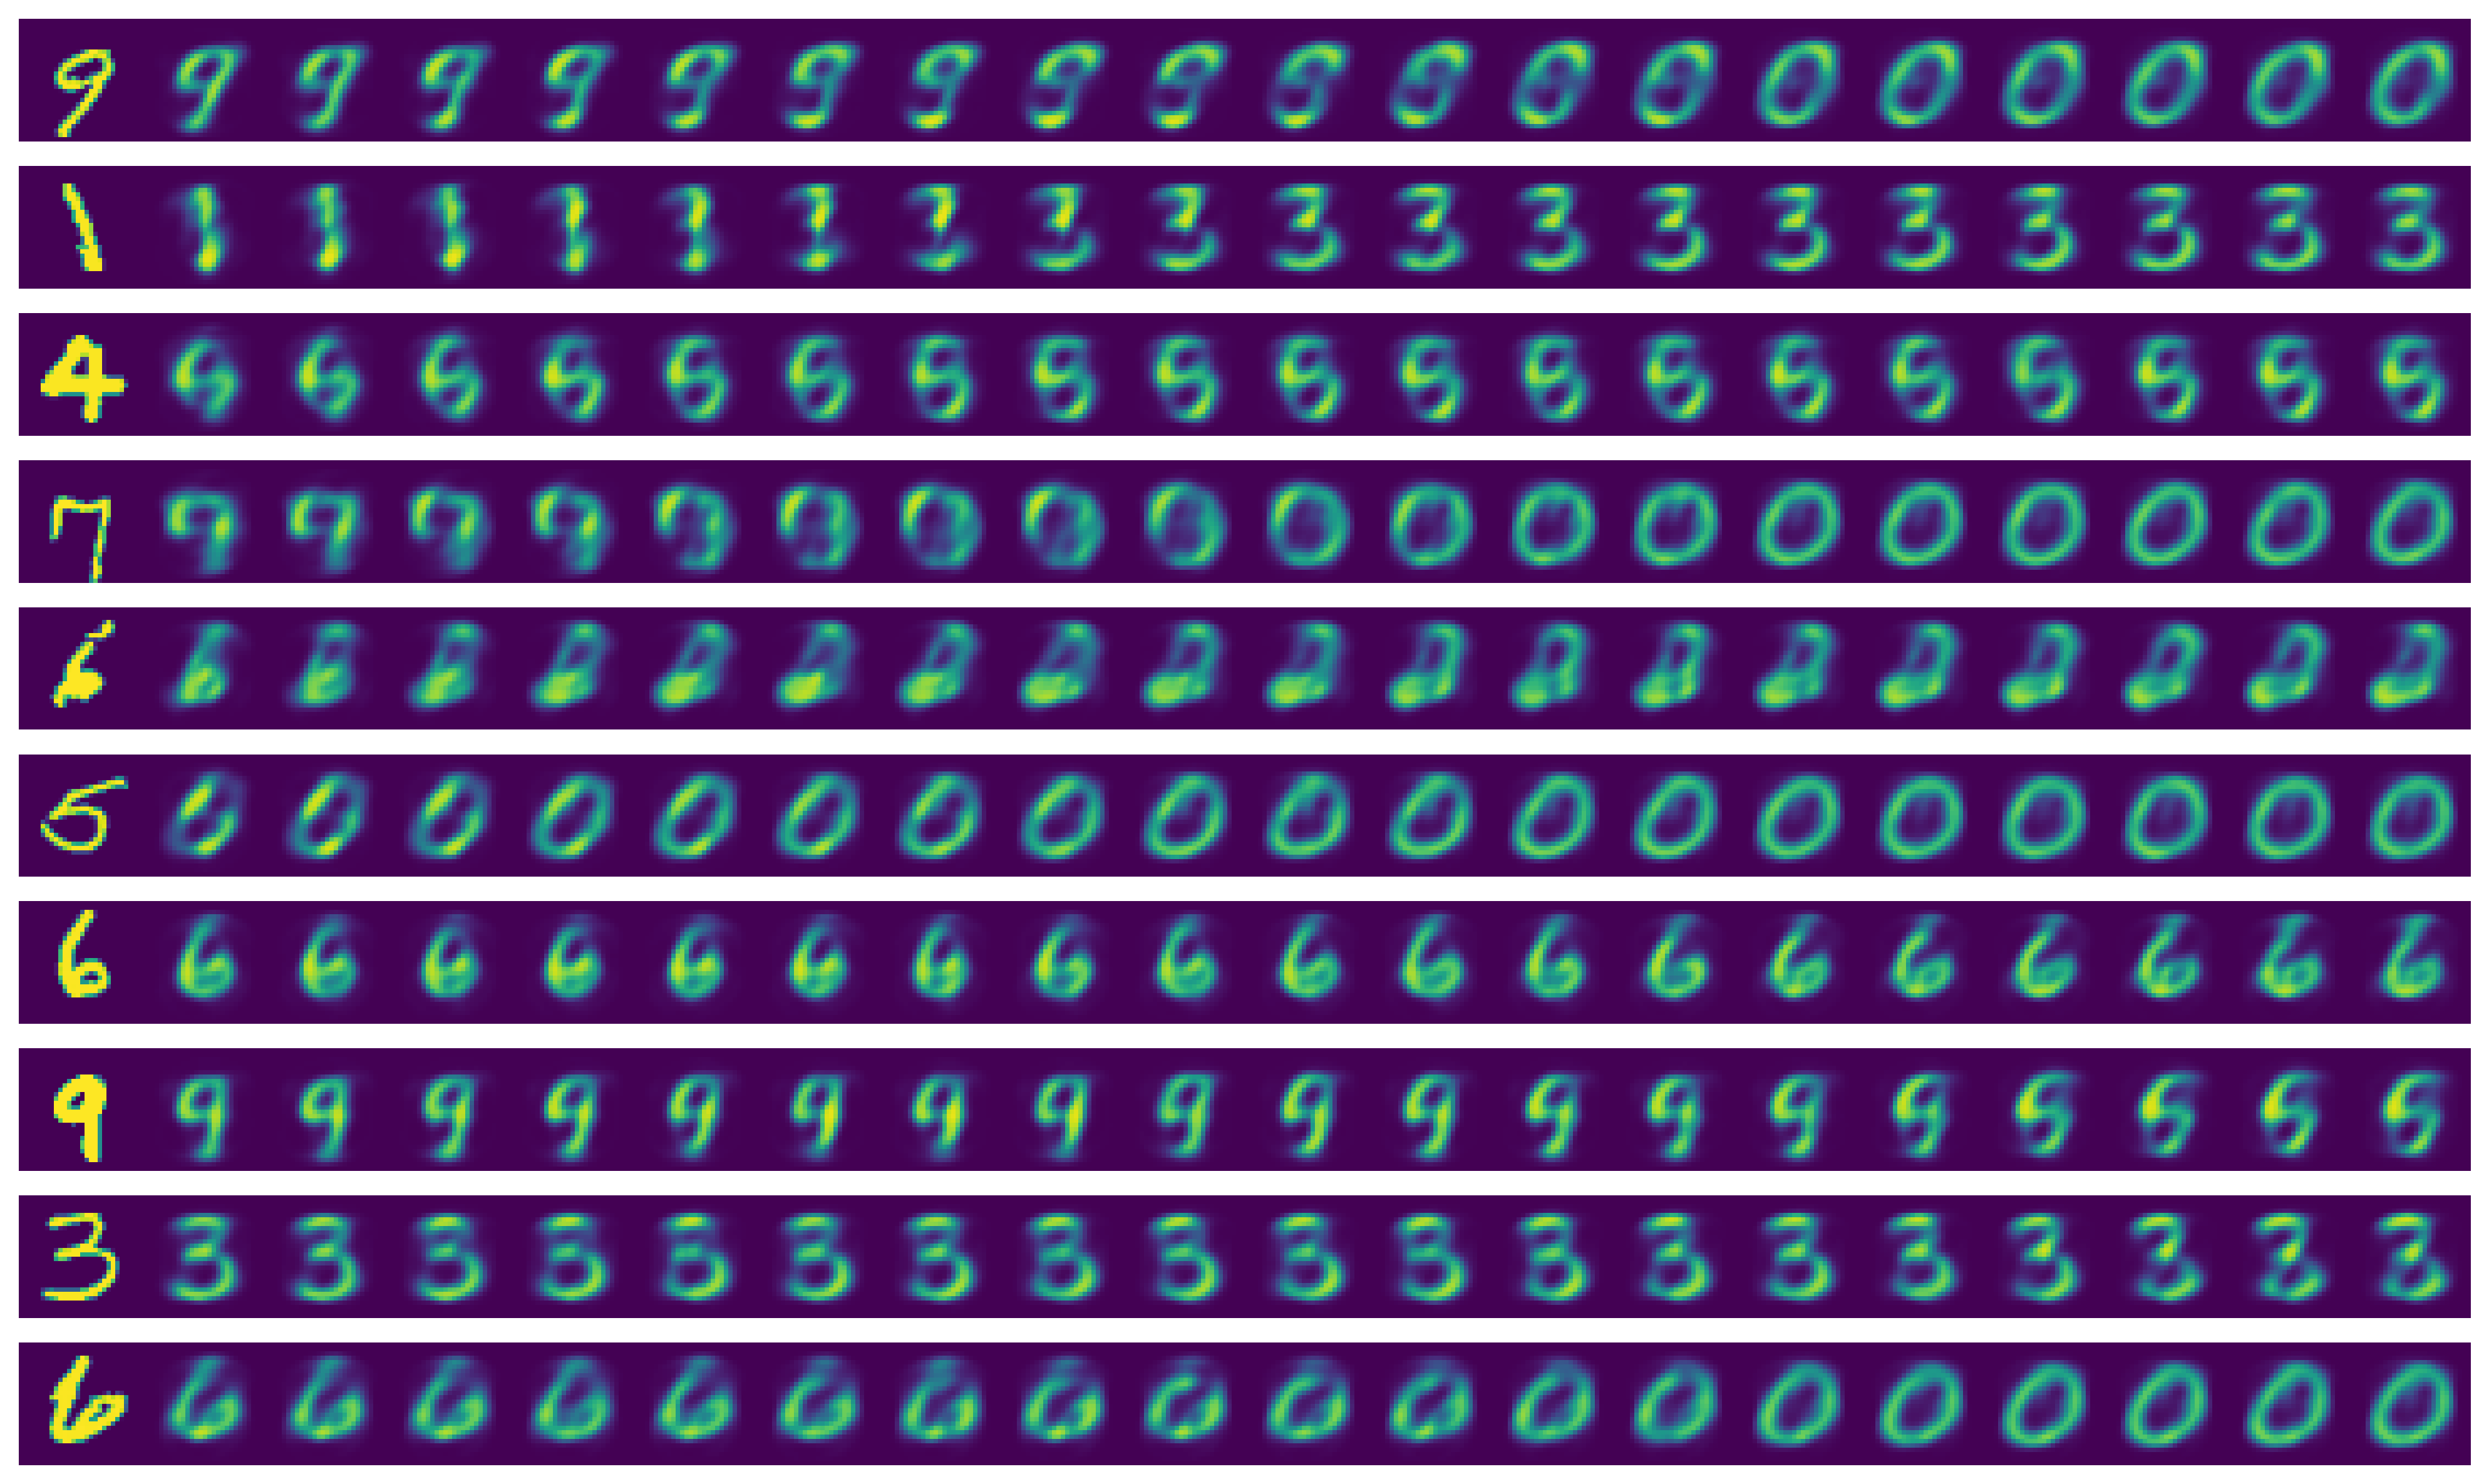

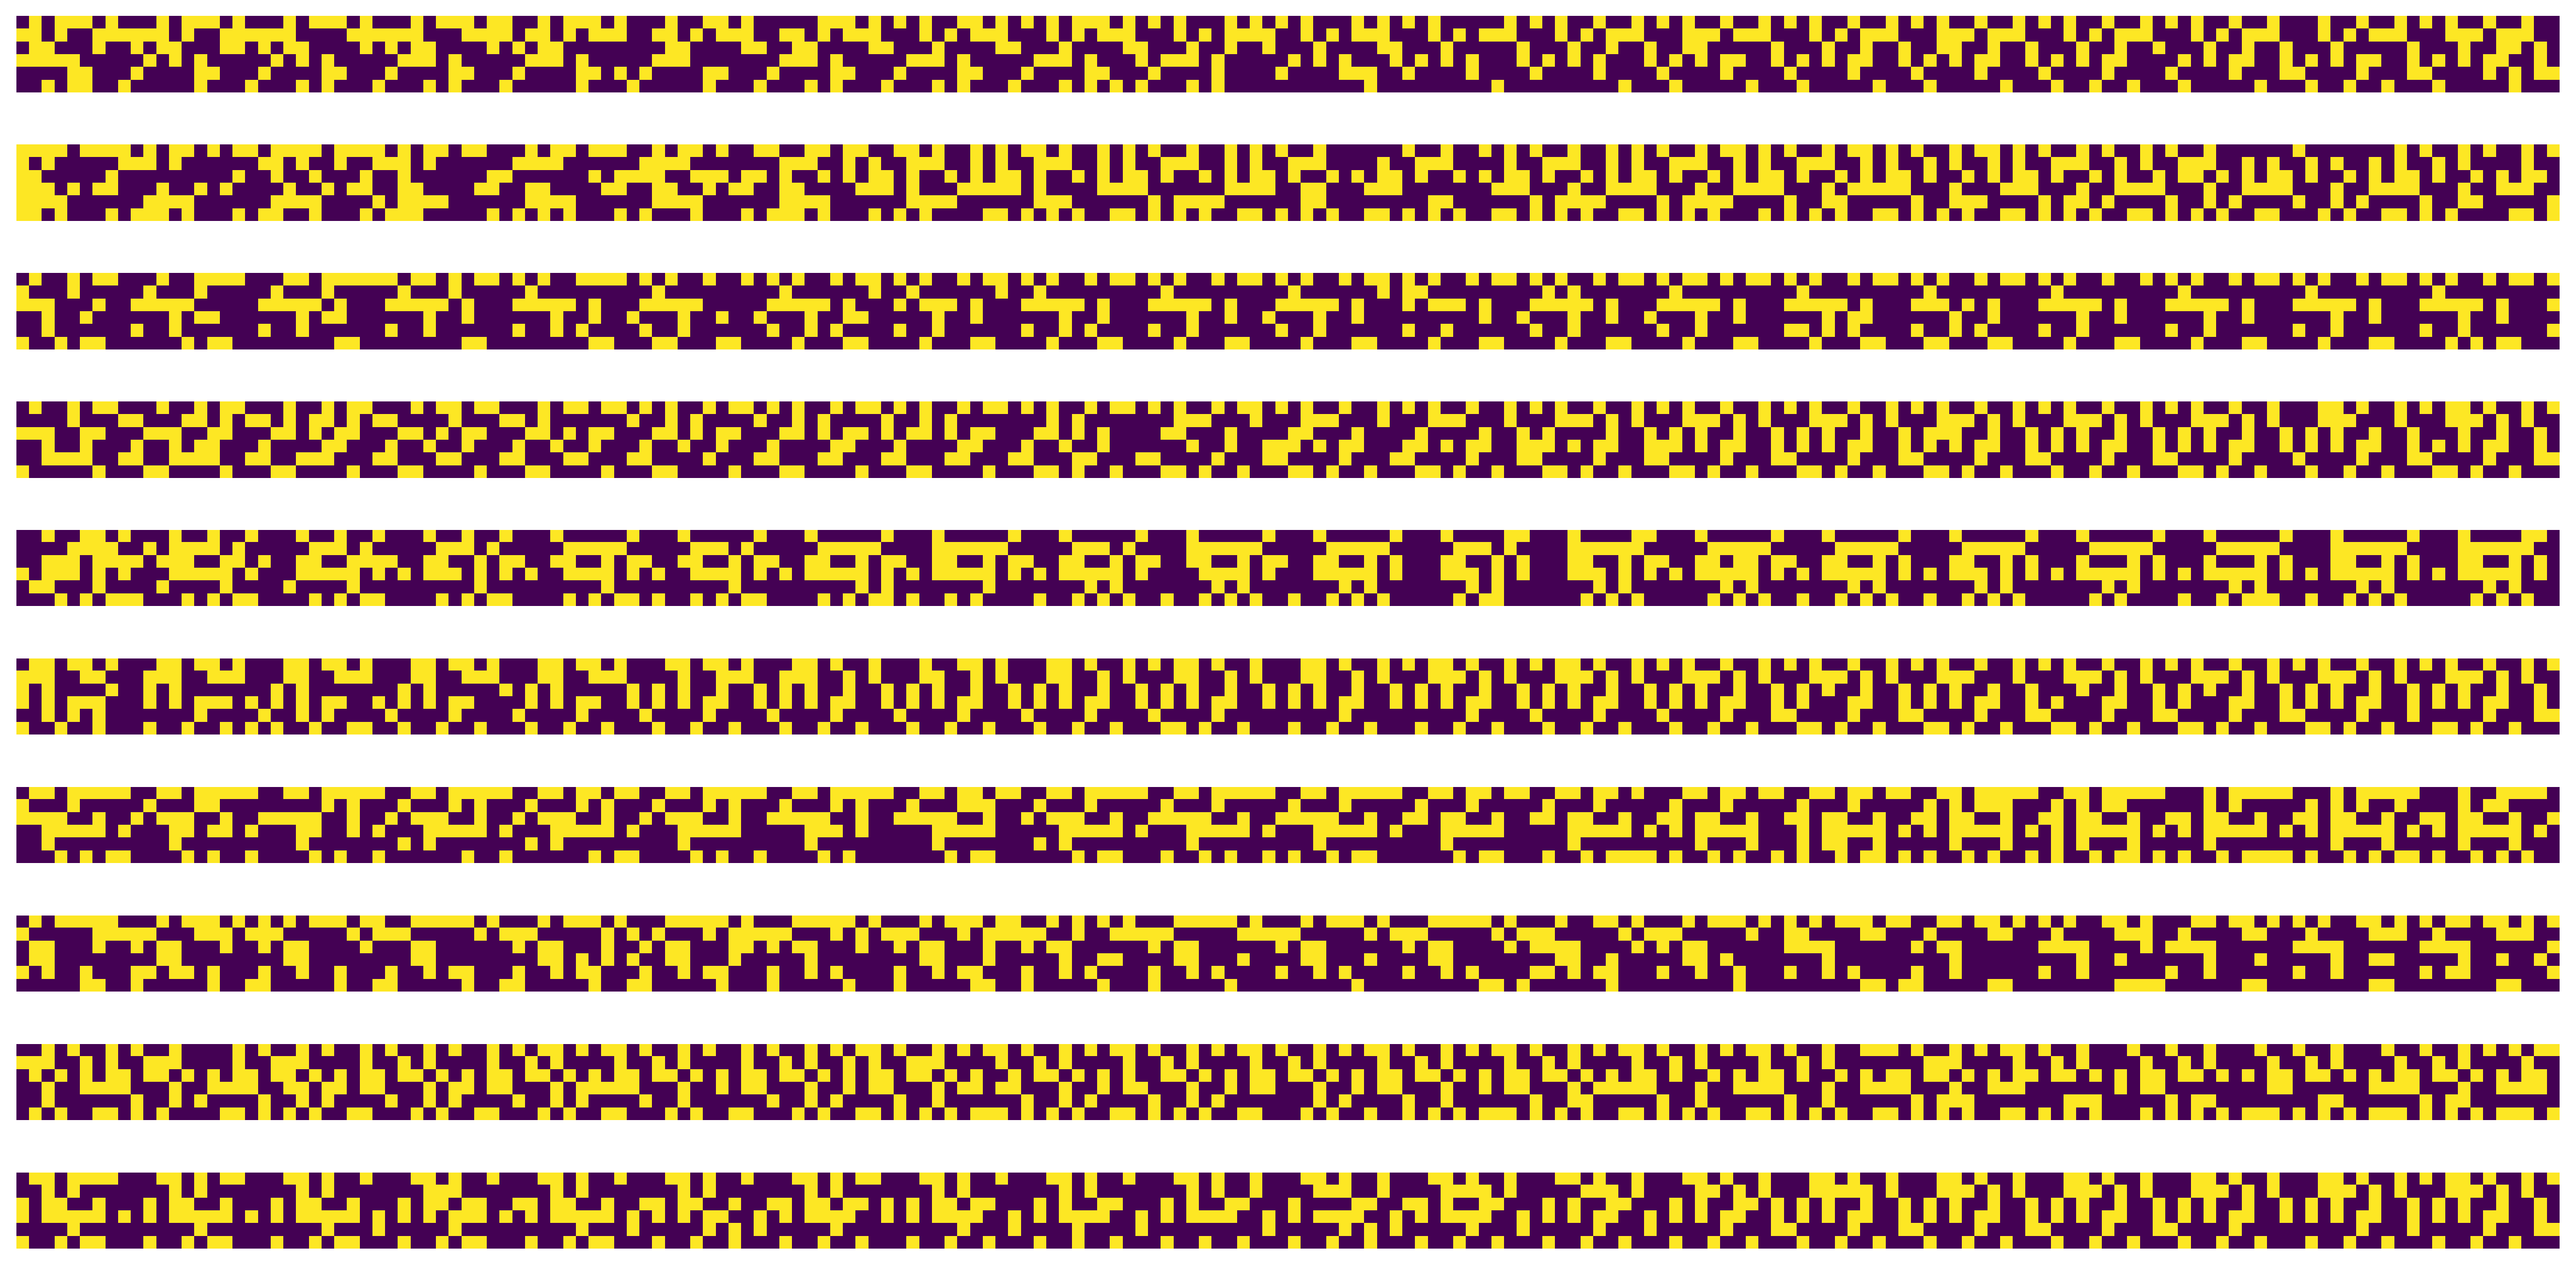

In [74]:
# Now: visualize the typical samples generated (from some starting point)
# run several times to continue this. It basically is a random walk
# through the space of all possible configurations, hopefully according
# to the probability distribution that has been trained!

## first set of plots shows samples from distribution of hidden neurons (-> images resembling MNIST images)
## second set of plots shows hidden neurons

nsteps=20
num_samples=20
test_samples=jnp.zeros([num_samples,batchsize,num_visible])
test_hidden=jnp.zeros([num_samples,batchsize,num_hidden])
skipsteps=1
substeps=400 # how many steps to take before showing a new picture

v_prime=jnp.zeros([batchsize,num_visible])
h=jnp.zeros([batchsize,num_hidden])
h_prime=jnp.zeros([batchsize,num_hidden])

v=produce_sample_images(batchsize,num_visible,x_train,random_key,
                       do_digitize=False)
    
for j in range(nsteps):
    for k in range(substeps):
        random_key,v,h,v_prime,h_prime=BoltzmannSequence(v,a,b,w,random_key,
                                  drop_h_prime=True,
                                  do_not_sample_v_prime=True) # step from v via h to v_prime!
    test_samples=test_samples.at[j%num_samples,:,:].set(v[:,:])
    test_hidden=test_hidden.at[j%num_samples,:].set(h[:,:])
    v=np.copy(v_prime) # use the new v as a starting point for next step!
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        fig,ax=plt.subplots(ncols=1,nrows=batchsize,figsize=(num_samples,batchsize))
        for n in range(batchsize):
            ax[n].imshow(jnp.transpose(jnp.reshape(jnp.transpose(jnp.reshape(test_samples[:,n,:],[num_samples,Npixels,Npixels]),
                                                    axes=[0,2,1]),[num_samples*Npixels,Npixels])),
                      interpolation='none')
            ax[n].axis('off')
        plt.show()
        fig,ax=plt.subplots(ncols=1,nrows=batchsize,figsize=(num_samples,batchsize))
        for n in range(batchsize):
            ax[n].imshow(jnp.transpose(jnp.reshape(jnp.transpose(jnp.reshape(test_hidden[:,n,:],[num_samples,6,10]),
                                                    axes=[0,2,1]),[num_samples*10,6])),
                      interpolation='none')
            ax[n].axis('off')
        plt.show()        